In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import yaml
import matplotlib.pyplot as plt
import warnings
import numpy as np
import cv2

warnings.filterwarnings("ignore")

C:\Users\Tony\PycharmProjects\BrainCancerDetection\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
with open(r"../config.yaml", "r") as yml_config:
    cfg = yaml.load(yml_config, Loader=yaml.FullLoader)

image_size = cfg["image"]["image_size"]
batch_size = cfg["image"]["batch_size"]
figure_size = (20, 10)

### Visualizing some of the brain MRI scans

Found 639 files belonging to 2 classes.
['healthy', 'tumor']


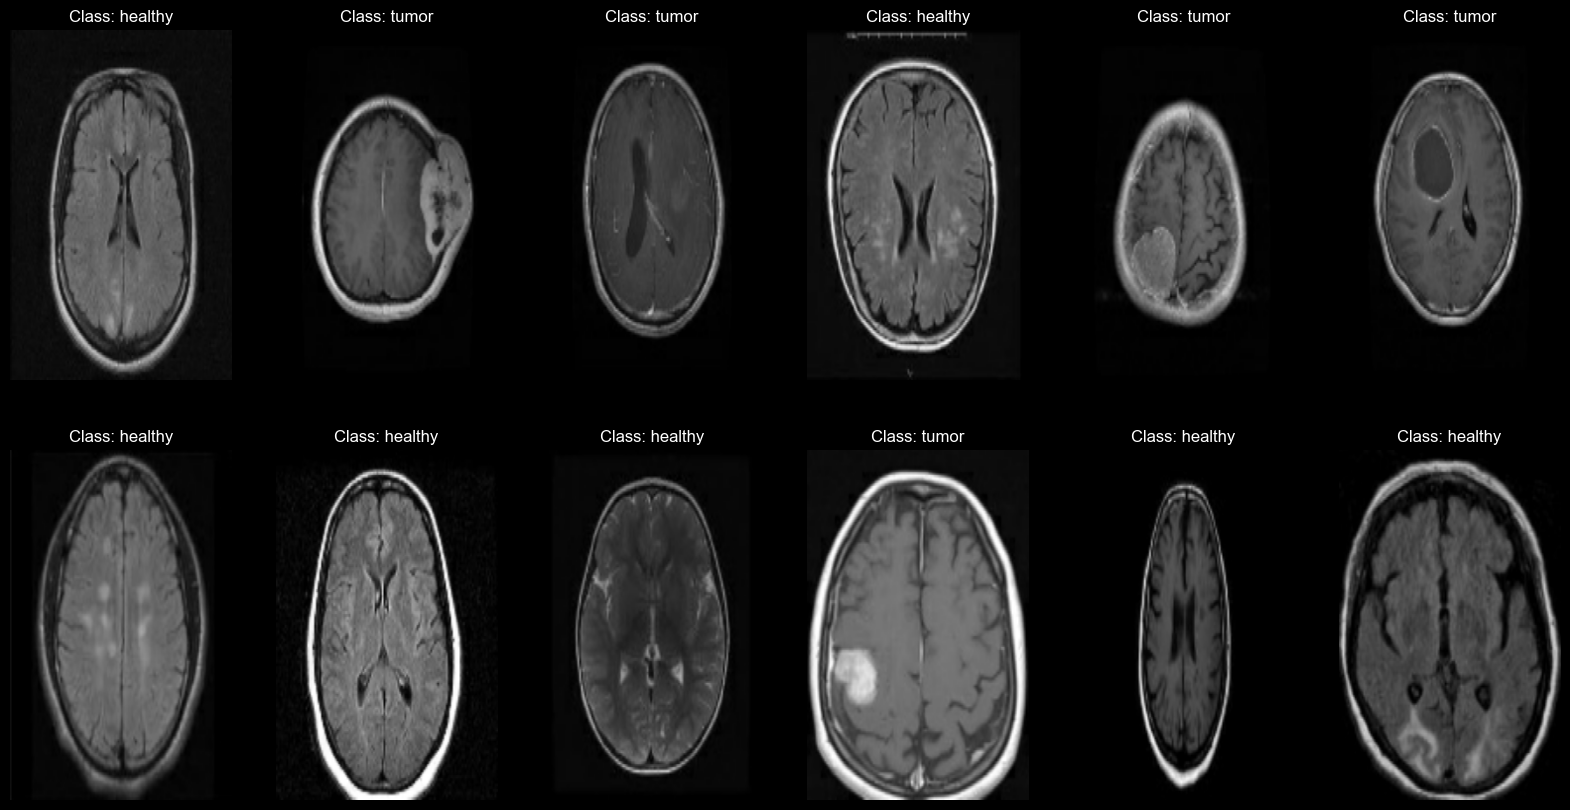

In [3]:
train_ds = image_dataset_from_directory(
    r"..\data\split\train",
    image_size=image_size,
    shuffle=True,
    batch_size=batch_size,
)

# Storing the classes
class_names = train_ds.class_names
print(class_names)


for images, labels in train_ds.take(1):
    plt.figure(figsize=figure_size)
    for _ in range(12):
        ax = plt.subplot(2, 6, _ + 1)
        plt.imshow(images[_].numpy().astype("uint8"), aspect="auto")
        class_name = train_ds.class_names[labels[_]]
        plt.title(f'Class: {class_name}')
        plt.axis('off')
    plt.show()

## Data Distribution

In [4]:
path = cfg['data'].get('split_data')
counts = {}
splits = os.listdir(path)

for split in splits:
    counts[split] = {}
    for cls in class_names:
        folder = os.path.join(path, split, cls)
        images = [image for image in os.listdir(folder) if image.lower().endswith((".jpg", ".jpeg", ".png"))]
        counts[split][cls] = len(images)

for key, val in counts.items():
    print(key, val)

test {'healthy': 41, 'tumor': 39}
train {'healthy': 326, 'tumor': 313}
val {'healthy': 41, 'tumor': 40}


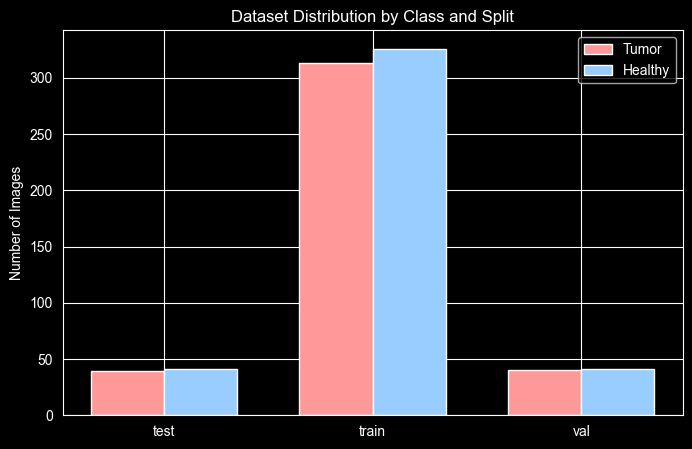

In [5]:
splits = list(counts.keys())
tumor_counts   = [counts[s]['tumor'] for s in splits]
healthy_counts = [counts[s]['healthy'] for s in splits]

#ploting To have a visual on the dataset
fig, ax = plt.subplots(figsize=(8,5))
bar_width = 0.35
x = range(len(splits))

ax.bar([i-bar_width/2 for i in x], tumor_counts, bar_width, label='Tumor', color='#FF9999')
ax.bar([i+bar_width/2 for i in x], healthy_counts, bar_width, label='Healthy', color='#99CCFF')

ax.set_xticks(x)
ax.set_xticklabels(splits)
ax.set_ylabel("Number of Images")
ax.set_title("Dataset Distribution by Class and Split")
ax.legend()
plt.show()


# Data Pipeline

#### Resizing the dataset

In [6]:
import sys
sys.path.append(os.path.abspath(".."))

from src.data_loader import load_data
from utils.resizing import resizing_data

path = cfg['data'].get('split_data')
resizing_data(path)

800 images successfully resized


In [7]:
# Reloading the data
train_ds, test_ds, val_ds = load_data(path)

Found 639 files belonging to 2 classes.
Found 80 files belonging to 2 classes.
Found 81 files belonging to 2 classes.


#### Normalizing the dataset

In [8]:
# Normalizing the split dataset
from utils.normalizer import normalize_layers

train_ds = normalize_layers(train_ds)
test_ds = normalize_layers(test_ds)
val_ds = normalize_layers(val_ds)

for images, labes in train_ds.take(1):
    print(f'Pixel range: {tf.reduce_min(images).numpy()} - {tf.reduce_max(images).numpy()}')

Pixel range: 0.0 - 1.0


#### Augmentation

In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])
# applying data Augmentation to the training dataset only
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

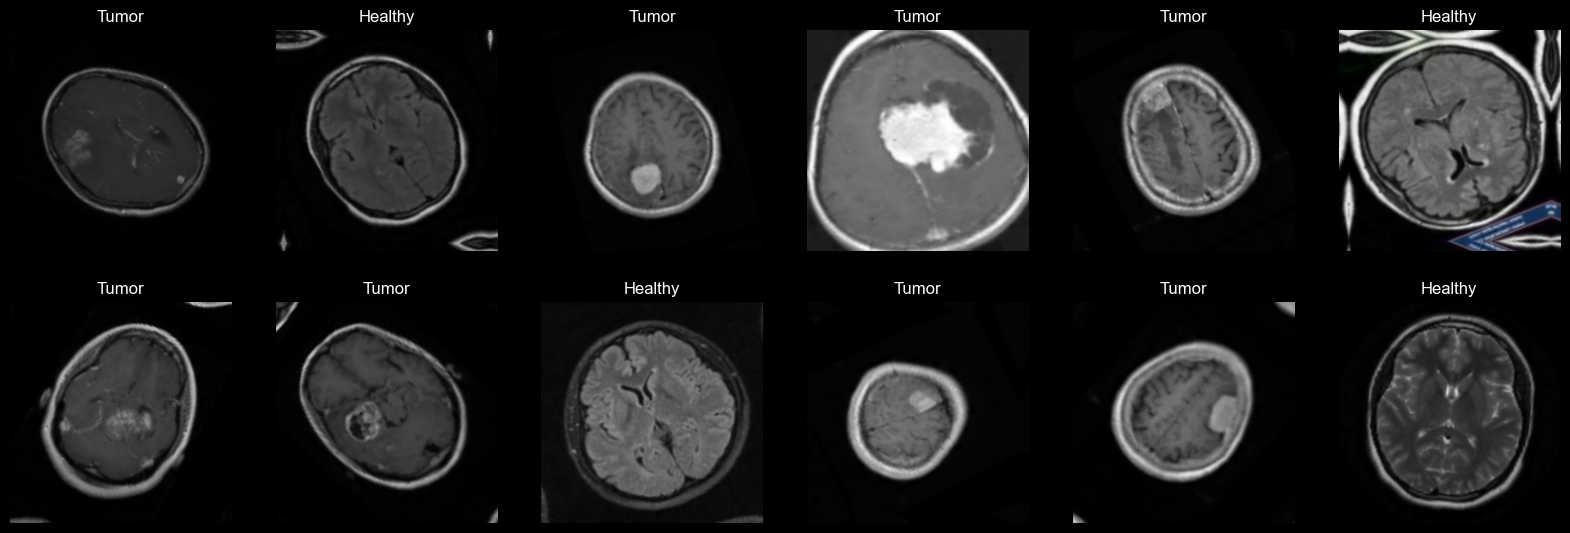

In [10]:
# plot for data augmented
for images, labels in train_ds.take(1):
    plt.figure(figsize=figure_size)
    for i in range(12):
        ax = plt.subplot(3,6,i+1)
        plt.imshow(tf.clip_by_value(images[i], 0.0, 1.0).numpy())
        plt.title("Tumor" if labels[i].numpy()==1 else "Healthy")
        plt.axis("off")
    plt.show()


#### Pipeline optimization (cache, shuffle & prefetch)

In [11]:
AUTOTUNE = tf.data.AUTOTUNE # Setting the Autotune value
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)